<a href="https://colab.research.google.com/github/rajatisdead/ridSER/blob/main/speechemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
Here is the filename identifiers as per the official RAVDESS website:

    
    Vocal channel (01 = speech, 02 = song).
    Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
    Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
    Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
    Repetition (01 = 1st repetition, 02 = 2nd repetition).
    Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).
'''

'\nHere is the filename identifiers as per the official RAVDESS website:\n\n    \n    Vocal channel (01 = speech, 02 = song).\n    Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).\n    Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the \'neutral\' emotion.\n    Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").\n    Repetition (01 = 1st repetition, 02 = 2nd repetition).\n    Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).\n'

In [ ]:
import glob  
import os  
import librosa  
import numpy as np  
from keras.models import Sequential  
from keras.layers import Dense, Activation  
from keras.layers import Dropout  
from sklearn.model_selection import train_test_split  
from sklearn.metrics import confusion_matrix  
import pandas as pd  
import seaborn as sns  
import matplotlib.pyplot as plt
import librosa.effects
from tqdm import tqdm
import librosa.display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
plt.style.use('ggplot')

In [ ]:
def create_df(path):
    dir_list = os.listdir(path)
    count = 0
    df = pd.DataFrame(columns = ['path', 'actor', 'gender','intensity', 'statement', 'repetition', 'emotion'])   
    for i in dir_list:
        filelist = os.listdir(path+'/'+i)
        for f in filelist:
            fname = f.split('.')[0].split('-')
            Path = path+'/'+i+'/'+f;
            actor = int(fname[-1])
            emotion = int(fname[2])
            if actor%2==0:
                gender = "Female"
            else: 
                gender = "Male"
            if fname[3] == '01':
                intensity = 0
            else:
                intensity = 1
        
            if fname[4] == '01':
                statement = 0
            else:
                statement = 1
        
            if fname[5] == '01':
                repeat = 0
            else:
                repeat = 1 
            df.loc[count] = [Path, actor, gender, intensity, statement, repeat, emotion]
            count = count+1
    return df        

In [ ]:
df = create_df('/content/drive/MyDrive/Audio_Speech_Actors_01-24')

In [ ]:
emos = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}

In [ ]:
def pie_chart(df):
    emo_name = []
    emo_number = []
    df_ = df.emotion.replace(emos)
    for i in df_.unique():
        print('%s: %d' %(i, np.sum(df_ == i)))
        emo_name.append(i)
        emo_number.append(np.sum(df_ == i))
    plt.pie(emo_number, labels=emo_name,
            autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.show()

neutral: 96
calm: 191
happy: 191
sad: 192
angry: 192
fear: 192
disgust: 192
surprise: 192


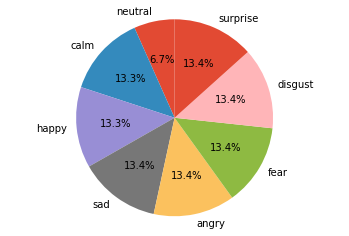

In [ ]:
pie_chart(df)

In [ ]:
df['time'] = df['path'].apply(lambda x: (len(librosa.load(x)[0]))/22050)

# Feature Extraction

Mean time is  3.7006836151243063


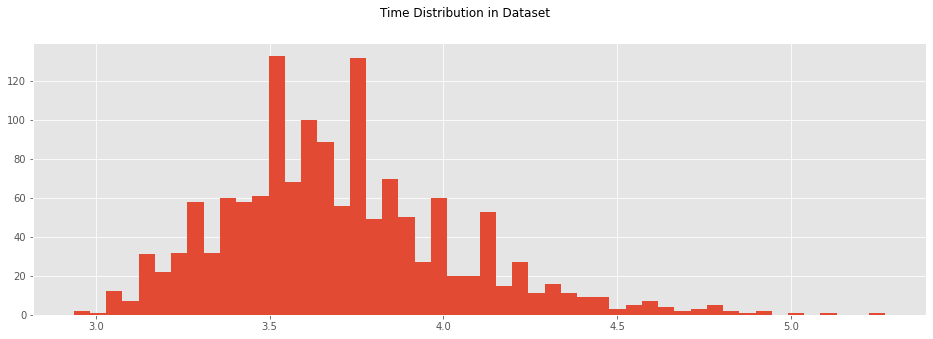

In [ ]:
df.groupby('statement').time.mean

fig, axes = plt.subplots(figsize=(16,5))
df.time.hist(bins=50,ax=axes)

plt.suptitle('Time Distribution in Dataset', ha='center', fontsize='large');

print("Mean time is ",np.mean(df.time))

In [ ]:
df.groupby('statement')

,time
,mean
statement,
0,3.722498
1,3.678930


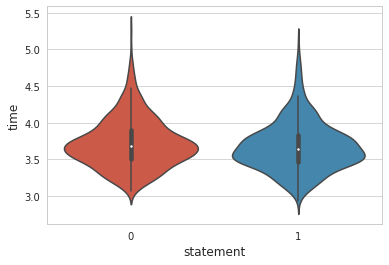

In [ ]:
sns.set_style('whitegrid')
sns.violinplot(x='statement', y='time', data=df)

In [ ]:
class AudioFeatureExtractor:
    
    def __init__(
            self,
            sampling_rate=22050,
            frame_length=2048,
            hop_ratio=4,audio_duration=3):
        
        self.sampling_rate = sampling_rate
        self.frame_length = frame_length
        self.hop_ratio = hop_ratio
        self.hop_length = int(self.frame_length / self.hop_ratio)
        self.audio_duration= audio_duration
        self.audio_length = self.audio_duration*self.sampling_rate

    def padding(self,file_path,df):
        data, _ = librosa.load(file_path, sr=self.sampling_rate)
        input_length = self.audio_length
        data = librosa.effects.preemphasis(data)
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        return data,int(df[df.path==file_path].emotion)-1

    def extract_melspectrogram(self, audio=None, S=None):
        
        if S is not None:
            S = np.abs(librosa.stft(
    audio, n_fft=self.frame_length, hop_length=self.hop_length, win_length=self.frame_length, window='hann')) ** 2
        melspectrogram = librosa.feature.melspectrogram(
            y=audio,
            S=S,
            sr=self.sampling_rate,
            n_fft=self.frame_length,
            hop_length=self.hop_length)
        melspectrogram = librosa.power_to_db(melspectrogram, ref=np.max)
        return melspectrogram

    def get_3d_spec(self,Sxx_in):
        
        base_mean, delta_mean, delta2_mean = (0, 0, 0)
        base_std, delta_std, delta2_std = (1, 1, 1)
        h, w = Sxx_in.shape
        right1 = np.concatenate([Sxx_in[:, 0].reshape((h, -1)), Sxx_in], axis=1)[:, :-1]
        delta = (Sxx_in - right1)[:, 1:]
        delta_pad = delta[:, 0].reshape((h, -1))
        delta = np.concatenate([delta_pad, delta], axis=1)
        right2 = np.concatenate([delta[:, 0].reshape((h, -1)), delta], axis=1)[:, :-1]
        delta2 = (delta - right2)[:, 1:]
        delta2_pad = delta2[:, 0].reshape((h, -1))
        delta2 = np.concatenate([delta2_pad, delta2], axis=1)
        base = (Sxx_in - base_mean) / base_std
        delta = (delta - delta_mean) / delta_std
        delta2 = (delta2 - delta2_mean) / delta2_std
        stacked = [arr.reshape((h, w, 1)) for arr in (base, delta, delta2)]
        return np.concatenate(stacked, axis=2)
   

In [ ]:
def parse_audio_files(df):  
    features, labels = np.empty([0,128,259,3]), np.empty(0)  # 130 features total. This can vary
    for file_path in tqdm(df.path):  
            try:
                X, label = af.padding(str(file_path),df)
                mfccs = af.extract_melspectrogram(X)
                mfccs = af.get_3d_spec(mfccs)
            except Exception as e:
                print("[Error] there was an error in feature extraction. %s" % (e))
                continue
 
            features = np.vstack([features, [mfccs]]) 
            labels = np.append(labels, label)
    return np.array(features), np.array(labels, dtype=np.int)

def save_feat(save_dir,features,labels):
    np.save(save_dir+'/'+'feat.npy', features)
    np.save(save_dir+'/'+'label.npy', labels)        

# Create Dataset and Train

In [ ]:
features, labels  = parse_audio_files(df)

100%|██████████| 1438/1438 [16:14<00:00,  1.48it/s]


In [ ]:
save_feat('/content/drive/MyDrive/features',features,labels)

In [ ]:
path = '/content/drive/MyDrive/features/'

In [ ]:
X = np.load(os.path.join(path,'feat.npy'))
y = np.load(os.path.join(path,'label.npy'))

In [ ]:
y = keras.utils.to_categorical(y, num_classes=8) 

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D,Conv2D, GlobalAveragePooling2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras.layers import Input, BatchNormalization, Flatten
from keras import regularizers
import tensorflow as tf


In [ ]:
basemodel = tf.keras.applications.ResNet50(
    include_top=False,weights="imagenet",
input_tensor=Input(shape=(128, 259, 3)))

In [ ]:
headmodel = basemodel.output

headmodel = AveragePooling2D(pool_size=(4, 4))(headmodel)
headmodel = Flatten(name="flatten")(headmodel)
headmodel = Dense(128, activation="relu")(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(8, activation="softmax",kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3))(headmodel)
model = tf.keras.Model(inputs=basemodel.input, outputs=headmodel)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 259, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 265, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 130, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 130, 64)  256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
for layer in basemodel.layers:
	layer.trainable = False

In [ ]:
opt = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 233)

In [ ]:
H=model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test))

Plotting

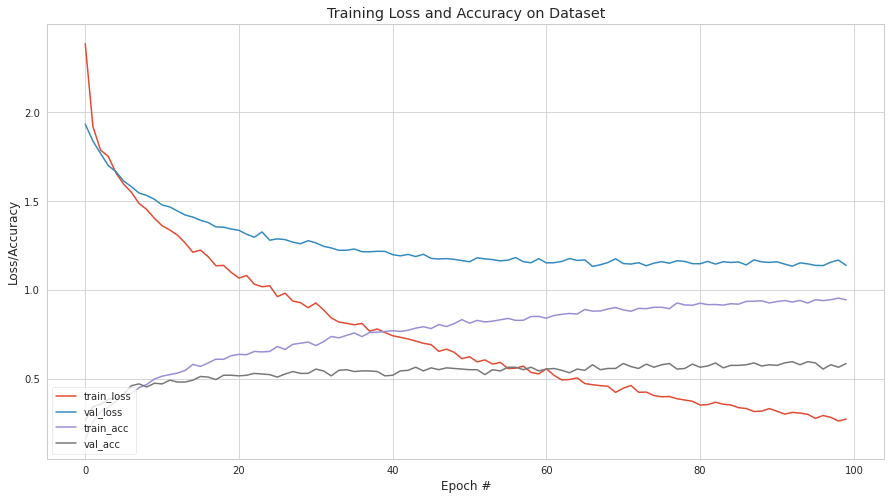

In [ ]:
N = 100
plt.figure(figsize=(15,8))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")